# 🦷 Multicollinearity Lab — Torque, ISQ, BIC

## 📋 Goal

Understand overlapping stability proxies and stabilize inference/prediction in dental implant research.

---

## 🎯 Clinical Context

When placing dental implants, clinicians measure multiple indicators of **primary stability**:

- **Insertion Torque (N·cm)**: mechanical resistance during placement
- **ISQ (Implant Stability Quotient)**: resonance frequency analysis
- **BIC (Bone-to-Implant Contact %)**: histomorphometric gold standard (rarely available clinically)

### The Problem

These measurements are **highly correlated** because they all reflect the same underlying construct: how well the implant is anchored in bone. When we include all three in a regression model predicting 12-month bone loss, we encounter **multicollinearity**—a statistical phenomenon that:

- Inflates standard errors
- Makes coefficients unstable
- Produces contradictory signs (e.g., torque positive, ISQ negative)
- Reduces interpretability

### What You'll Learn

1. **Diagnose multicollinearity** using correlation heatmaps, VIF, and condition numbers
2. **Understand the clinical implications** of collinear predictors
3. **Apply statistical remedies**: composite indices, regularization (Ridge/Lasso), and dimensionality reduction (PCA)
4. **Communicate findings** to clinical teams responsibly


## 0️⃣ Setup & Environment

### 📦 What We're Installing

Before running this notebook, ensure you've created a virtual environment and installed dependencies:

```bash
python -m venv .venv
source .venv/bin/activate  # On Windows: .venv\Scripts\activate
pip install -r requirements.txt
```

### 🛠 Key Libraries

- **NumPy & Pandas**: data manipulation
- **Matplotlib & Seaborn**: visualization
- **Statsmodels**: VIF, OLS regression, diagnostics
- **Scikit-learn**: regularization (Ridge/Lasso), PCA, cross-validation

Let's import everything we need:


In [1]:
# TODO: import numpy, pandas, matplotlib.pyplot as plt, seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# TODO: import statsmodels.api as sm, statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.stats.api as sms


In [3]:
# TODO: from sklearn import preprocessing, linear_model, decomposition, model_selection
from sklearn import preprocessing, linear_model, decomposition, model_selection


---

## 1️⃣ Load Data & Quick EDA

### 📁 Dataset: `implants_stability_300.csv`

Our dataset contains **300 dental implants** with the following structure:

#### 🔬 Stability Measures (our main predictors)
- `torque_ncm`: Insertion torque (Newton-centimeters)
- `bic_percent`: Bone-to-Implant Contact (% surface area)
- `isq_w0`, `isq_w1`, ..., `isq_w8`: ISQ measured at weeks 0, 1, 2, 3, 4, 6, 8

#### 🦴 Bone Quality Indicators
- `density`: bone density class (D1/D2/D3/D4, Lekholm-Zarb)
- `cortical_thickness_mm`: cortical bone thickness

#### 🔩 Implant Characteristics
- `diameter_mm`: implant diameter
- `length_mm`: implant length
- `design`: thread design (categorical)
- `surface`: surface treatment (categorical)

#### 📍 Clinical Variables
- `arch`: maxilla vs mandible
- `site_type`: molar, premolar, anterior
- `immediate_load`: yes/no

#### 🎯 Outcome Variable
- `bone_loss_12m_mm`: marginal bone loss at 12 months (mm)

### 📊 What to Look For

During EDA, we want to:
1. Check for missing values
2. Verify ranges (e.g., ISQ should be 0-100, torque typically 10-50 N·cm)
3. Understand distributions (are they normal? skewed?)
4. Identify outliers

Let's load and inspect:


In [4]:
# TODO: read CSV -> DataFrame df
# Hint: df = pd.read_csv('../data/raw/implants_stability_300.csv')
df = pd.read_csv('../data/raw/implants_stability_300.csv')
print(df.head())

   patient_id  implant_id  age_years     sex  smoker  diabetes     arch  \
0           1           1         60    male       0         0  maxilla   
1           2           2         53    male       0         0  maxilla   
2           3           3         62  female       0         0  maxilla   
3           4           4         73  female       0         0  maxilla   
4           5           5         52  female       0         0  maxilla   

   site_type  bone_density bone_class  ...  isq_w0 isq_w1 isq_w2  isq_w3  \
0  immediate         0.843         D2  ...    90.0   90.0   90.0    90.0   
1     healed         0.840         D2  ...    89.7   90.0   89.9    90.0   
2     healed         0.888         D1  ...    90.0   90.0   90.0    90.0   
3  immediate         0.670         D4  ...    80.3   79.7   81.7    87.0   
4  immediate         0.759         D3  ...    82.5   82.0   79.1    81.3   

   isq_w4  isq_w6  isq_w8 bic_percent  bone_loss_12m_mm  outcome_success_12m  
0    90.0    

In [5]:
# TODO: df.info(), describe(); check ranges for torque_ncm, bic_percent, isq_* columns
# Look for:
# - torque_ncm: typically 10-50 N·cm
# - bic_percent: 0-100%
# - isq_*: 0-100 scale
# - bone_loss_12m_mm: typically 0-3 mm (higher = worse outcome)
print(df.describe())
print(df.info())
print(df.columns)
print(df.dtypes)
print(df.isnull().sum())
print(df.isnull().sum() / len(df))
print(df.isnull().sum() / len(df) * 100)




       patient_id  implant_id   age_years      smoker    diabetes  \
count  300.000000  300.000000  300.000000  300.000000  300.000000   
mean   150.500000  150.500000   54.410000    0.193333    0.106667   
std     86.746758   86.746758   11.556835    0.395572    0.309205   
min      1.000000    1.000000   20.000000    0.000000    0.000000   
25%     75.750000   75.750000   46.000000    0.000000    0.000000   
50%    150.500000  150.500000   55.000000    0.000000    0.000000   
75%    225.250000  225.250000   62.000000    0.000000    0.000000   
max    300.000000  300.000000   85.000000    1.000000    1.000000   

       bone_density    cortical  diameter_mm   length_mm  immediate_prov  ...  \
count    300.000000  300.000000   300.000000  300.000000      300.000000  ...   
mean       0.810000    0.647887     4.076900   10.551667        0.423333  ...   
std        0.097485    0.128755     0.379545    1.465260        0.494913  ...   
min        0.543000    0.341000     3.300000    8.0000

---

## 2️⃣ Correlations & Heatmap

### 🔍 Why Correlation Matters

**Multicollinearity** begins with high correlations between predictors. When two variables are highly correlated (|r| > 0.7), they carry **redundant information**.

### 🧠 Clinical Intuition

We expect:
- **High correlation** between `torque_ncm`, `bic_percent`, and `isq_w0` (all measure primary stability)
- **Moderate correlation** among sequential ISQ measurements (ISQ changes over healing)
- **Lower correlation** between stability measures and implant geometry

### 📊 What the Heatmap Tells Us

- **Deep red/blue** (|r| > 0.8): Strong collinearity—these variables may be measuring the same thing
- **Light colors** (|r| < 0.3): Weak relationship—safe to include together
- **Negative correlations**: Not necessarily bad, but think about the mechanism (e.g., higher density → higher ISQ)

### ⚠️ Clinical Trap

Just because two variables correlate doesn't mean we should exclude one arbitrarily. The heatmap is a **diagnostic tool**, not a decision rule.

Next, we'll use VIF (Variance Inflation Factor), which quantifies how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors. In other words, VIF tells us if a variable is highly redundant when considered alongside the rest of the model. This lets us *quantify* the problem, rather than just visually guessing from the heatmap.

Let's visualize:


In [6]:
# TODO: select numeric stability features (e.g., torque_ncm, bic_percent, isq_w0, density, cortical, diameter_mm)
# Hint: cols = ['torque_ncm', 'bic_percent', 'isq_w0', 'cortical_thickness_mm', 'diameter_mm', 'bone_loss_12m_mm']
# Some numeric columns are in reality boolean because they are 0/1. We need to create the category of boolean columns.
# Check which columns have max value 1 and min value 0.
boolean_cols = df.columns[df.max() == 1]
print("'boolean_cols' Boolean columns with values 0/1: ", boolean_cols)

# Columns that are text. These are the categorical columns.
categorical_cols = df.columns[df.dtypes == 'object']
print("'categorical_cols' Categorical columns: ", categorical_cols)

# Choose numeric features, but exclude columns that are 0/1 and thus actually boolean
numeric_cols = [
    'age_years',
    'torque_ncm',
    'bic_percent',
    'isq_w0', 'isq_w1', 'isq_w2', 'isq_w3', 'isq_w4', 'isq_w6', 'isq_w8',
    'diameter_mm',
    'length_mm',
    'bone_loss_12m_mm'
    # Note: Do NOT include columns like smoker, diabetes, bone_density, cortical, etc. 
    # because they're 0/1 or really categorical/boolean (see printout)
]


'boolean_cols' Boolean columns with values 0/1:  Index(['smoker', 'diabetes', 'bone_density', 'cortical', 'immediate_prov',
       'antibiotics', 'grafting', 'outcome_success_12m'],
      dtype='object')
'categorical_cols' Categorical columns:  Index(['sex', 'arch', 'site_type', 'bone_class', 'implant_design', 'surface',
       'occlusion_load'],
      dtype='object')


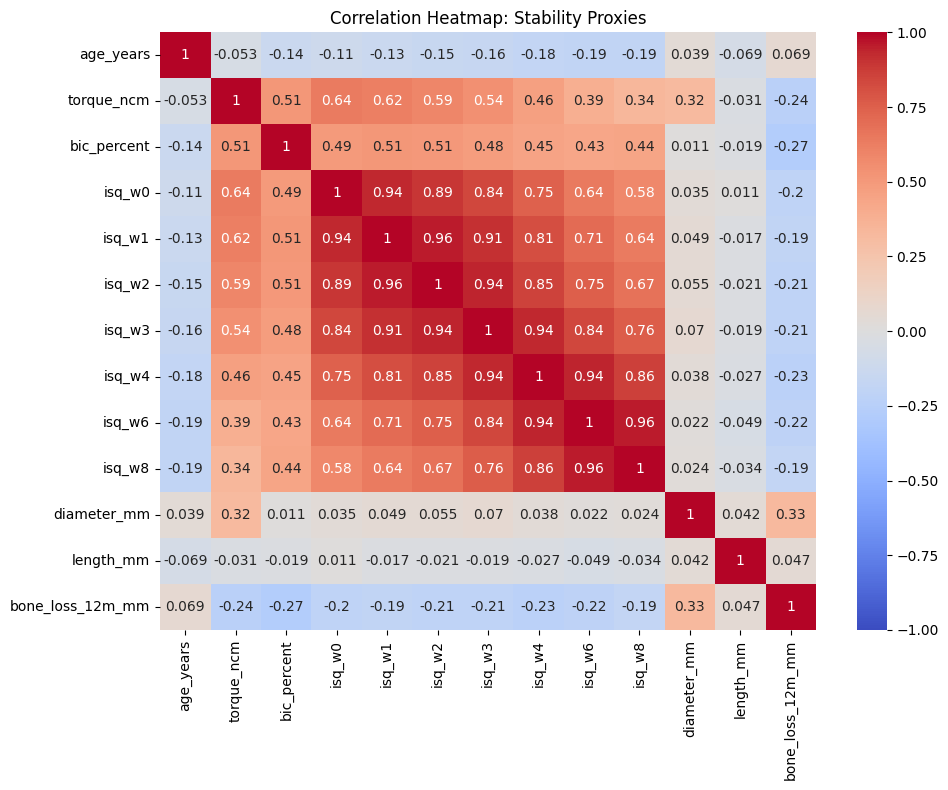

In [7]:
# TODO: compute df[cols].corr() and plot heatmap (sns.heatmap, annot=True, vmin=-1, vmax=1)
# Hint:
# corr_matrix = df[cols].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Correlation Heatmap: Stability Proxies')
# plt.tight_layout()
corr_matrix = df[numeric_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap: Stability Proxies')
plt.tight_layout()
plt.savefig("../images/correlation_heatmap_stability_proxies.png", dpi=150)
plt.show()



---

## 3️⃣ VIF and Condition Number

### 📐 What is VIF (Variance Inflation Factor)?

VIF quantifies **how much the variance of a regression coefficient is inflated** due to multicollinearity.

$$VIF_j = \frac{1}{1 - R^2_j}$$

Where $R^2_j$ is the R-squared from regressing predictor $j$ on all other predictors.

### 🎯 Interpretation Guidelines

| VIF Value | Interpretation | Action |
|-----------|----------------|--------|
| **1** | No correlation | Safe ✅ |
| **1-5** | Moderate correlation | Monitor 👀 |
| **5-10** | High correlation | Consider remedies ⚠️ |
| **> 10** | Severe multicollinearity | Must address 🚨 |

### 🧮 Condition Number

The **condition number** is the ratio of the largest to smallest eigenvalue of the correlation matrix:

$$\kappa = \frac{\lambda_{max}}{\lambda_{min}}$$

- **κ < 30**: No serious multicollinearity
- **κ > 30**: Multicollinearity present
- **κ > 100**: Severe multicollinearity

### 🦷 Clinical Meaning

High VIF means: "If I measure torque, ISQ, and BIC on the same implant, I'm essentially measuring the same underlying stability three times. My regression can't tell them apart, so the coefficients become unreliable."

Let's compute:


In [8]:
# TODO: build design matrix X with a constant; compute VIF per column
# hint: use statsmodels.stats.outliers_influence.variance_inflation_factor
#
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[numeric_cols].dropna()
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X.columns))]
print(vif_data.sort_values('VIF', ascending=False))


             Feature        VIF
8             isq_w6  32.162909
7             isq_w4  25.955078
6             isq_w3  23.693851
4             isq_w1  21.021776
5             isq_w2  20.190611
9             isq_w8  14.013933
3             isq_w0   8.801698
1         torque_ncm   2.444063
2        bic_percent   1.627419
10       diameter_mm   1.484226
12  bone_loss_12m_mm   1.381652
0          age_years   1.057630
11         length_mm   1.029196


In [9]:
# Now that we stated that high collinearity exists between isq_w0 and isq_w1, isq_w3, isq_w4, isq_w6, we can remove isq_w1, isq_w3, isq_w4, and isq_w6 from the VIF calculation and keep only baseline ISQ.
cols_for_vif = [
    'torque_ncm',
    'bic_percent',
    'isq_w0',             # Only baseline ISQ!
    'diameter_mm',
    'length_mm',
    'age_years',
    'bone_loss_12m_mm'    # outcome
]

X = df[cols_for_vif].dropna()
X_with_const = sm.add_constant(X)


vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i+1) 
                    for i in range(len(X.columns))]
print(vif_data.sort_values('VIF', ascending=False))

safe_numeric_cols = vif_data[vif_data['VIF'] < 5]['Feature'].tolist()

            Feature       VIF
0        torque_ncm  2.380431
2            isq_w0  1.898526
1       bic_percent  1.507985
3       diameter_mm  1.451312
6  bone_loss_12m_mm  1.333570
5         age_years  1.031462
4         length_mm  1.012237


In [10]:
# TODO: standardize X (without the constant) and compute condition number (np.linalg.cond)
# Hint:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
condition_number = np.linalg.cond(X_scaled)
print(f'Condition Number: {condition_number:.2f}')
if condition_number > 30:
    print('⚠️  Multicollinearity detected!')


Condition Number: 2.96


The condition number is 2.96 which is below 30, so we can say that there is no multicollinearity in the data. Now we can proceed with the analysis and build the baseline model safely.

### 🤔 Reflection Questions

After computing VIF and condition number, ask yourself:
1. Which variables have the highest VIF?
2. Do the high-VIF variables make clinical sense? (They should be the stability proxies)
3. What would happen if you tried to interpret the regression coefficients of these variables?

---


## 4️⃣ OLS Baseline for 12-Month Bone Loss

### 🎯 Research Question

**"Which stability measures predict 12-month marginal bone loss?"**

### 📊 Model Specification

We'll fit an **Ordinary Least Squares (OLS)** regression:

$$\text{bone\_loss\_12m} = \beta_0 + \beta_1 \cdot \text{torque} + \beta_2 \cdot \text{ISQ} + \beta_3 \cdot \text{BIC} + \ldots + \epsilon$$

### 🔧 What to Include

**Predictors:**
- Stability proxies: `torque_ncm`, `isq_w0`, `bic_percent`
- Bone quality: `cortical_thickness_mm`, `density` (categorical)
- Implant: `diameter_mm`, `length_mm`, `design`, `surface`
- Clinical: `arch`, `site_type`, `immediate_load`

**Outcome:**
- `bone_loss_12m_mm` (continuous, higher = worse)

### ⚠️ Expected Problem

Because `torque_ncm`, `isq_w0`, and `bic_percent` are **highly correlated**, we expect:
- **Inflated standard errors**: Wide confidence intervals
- **Unstable coefficients**: Small data changes → big coefficient changes
- **Contradictory signs**: E.g., torque positive but ISQ negative (makes no clinical sense)

### 🧠 Clinical Interpretation Challenge

Imagine telling a surgeon: *"For every 1 N·cm increase in torque, bone loss increases by 0.05 mm, but for every 1-point increase in ISQ, bone loss decreases by 0.03 mm."*

The surgeon asks: *"But torque and ISQ both indicate stability—why do they have opposite effects?"*

**Answer**: They don't. The model is confused by multicollinearity.

Let's fit the baseline model:


In [12]:
# TODO: one-hot encode categoricals (arch, site_type, design, surface) -> X
# Hint:
# Need all features as NUMERICAL. All categorical dummies must be int, not bool!

boolean_cols = [
    'smoker', 'diabetes', 'bone_density', 'cortical', 'immediate_prov',
    'antibiotics', 'grafting'
]
categorical_cols = [
    'sex', 'arch', 'site_type', 'bone_class', 'implant_design',
    'surface', 'occlusion_load'
]

# Correct one-hot encoding: use get_dummies(drop_first=True)
safe_numeric_cols = [
    'torque_ncm', 'bic_percent', 'isq_w0', 'diameter_mm', 'length_mm', 'age_years'
]

final_categorical_cols = [
    'sex_male', 'arch_maxilla', 'site_type_immediate',
    'bone_class_D2', 'bone_class_D3', 'bone_class_D4',
    'implant_design_tapered', 'surface_other',
    'occlusion_load_light', 'occlusion_load_normal'
]

# One-hot encode categorical columns; ensure outputs are numeric (int)
dummies = pd.get_dummies(
    df[categorical_cols],
    drop_first=True
)

# Select only the needed final categorical columns & make them int (not bool)
encoded_cat_dummies = dummies[final_categorical_cols].astype(int)

# Concatenate numeric features, categorical dummies (all int), and boolean/int columns
X = pd.concat([
    df[safe_numeric_cols],           # continuous and integer features
    encoded_cat_dummies,             # categorical dummies as int
    df[boolean_cols].astype(int)     # boolean columns as int
], axis=1)

# Drop rows with missing outcome
mask = df['bone_loss_12m_mm'].notna()
X = X.loc[mask]
y = df.loc[mask, 'bone_loss_12m_mm']

# Display shape, column names, dtypes
print(f"Final feature matrix: {X.shape}")
print(f"Columns: {list(X.columns)}")
print(X.dtypes)

Final feature matrix: (300, 23)
Columns: ['torque_ncm', 'bic_percent', 'isq_w0', 'diameter_mm', 'length_mm', 'age_years', 'sex_male', 'arch_maxilla', 'site_type_immediate', 'bone_class_D2', 'bone_class_D3', 'bone_class_D4', 'implant_design_tapered', 'surface_other', 'occlusion_load_light', 'occlusion_load_normal', 'smoker', 'diabetes', 'bone_density', 'cortical', 'immediate_prov', 'antibiotics', 'grafting']
torque_ncm                float64
bic_percent               float64
isq_w0                    float64
diameter_mm               float64
length_mm                 float64
age_years                   int64
sex_male                    int64
arch_maxilla                int64
site_type_immediate         int64
bone_class_D2               int64
bone_class_D3               int64
bone_class_D4               int64
implant_design_tapered      int64
surface_other               int64
occlusion_load_light        int64
occlusion_load_normal       int64
smoker                      int64
diabetes   

In [14]:
# TODO: fit sm.OLS(y, X_with_const).fit(); inspect params and conf_int()
# NOTE: expect inflated SEs if you include torque + isq + bic together.
#
# Hint:
X_with_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())
#
# # Extract stability coefficients
# stability_vars = ['torque_ncm', 'isq_w0', 'bic_percent']
# stability_results = ols_model.params[stability_vars]
# stability_ci = ols_model.conf_int().loc[stability_vars]
# print('\nStability Coefficients:')
# print(pd.concat([stability_results, stability_ci], axis=1))


                            OLS Regression Results                            
Dep. Variable:       bone_loss_12m_mm   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     12.42
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           8.86e-31
Time:                        18:33:59   Log-Likelihood:                 313.24
No. Observations:                 300   AIC:                            -578.5
Df Residuals:                     276   BIC:                            -489.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

### 🔍 What to Observe

After fitting the baseline model, check:
1. **Coefficient signs**: Do they make clinical sense?
2. **Standard errors**: Are they large relative to coefficients?
3. **Confidence intervals**: Do they cross zero? Are they very wide?
4. **P-values**: Are the stability variables significant despite being correlated?

**Key insight**: Even if p-values are significant, the **individual coefficients are not interpretable** when multicollinearity is severe.

---


## 5️⃣ Remedies for Multicollinearity

### 🛠 Three Strategic Approaches

Now that we've diagnosed the problem, let's fix it. We'll try **three remedies**, each with different trade-offs:

| Approach | Strategy | Pros | Cons |
|----------|----------|------|------|
| **Composite Index** | Combine correlated variables into one score | Simple, interpretable | Loses individual contributions |
| **Regularization** | Shrink coefficients (Ridge/Lasso) | Improves prediction | Coefficients biased toward zero |
| **PCA/PLS** | Extract uncorrelated components | Removes collinearity entirely | Loses interpretability |

---

### 🧮 Remedy 1: Composite Stability Index

#### 💡 Idea

If torque, ISQ, and BIC all measure "primary stability," why not **combine them into one variable**?

$$\text{StabilityIndex} = \frac{z_{\text{torque}} + z_{\text{ISQ}} + z_{\text{BIC}}}{3}$$

Where $z$ denotes standardized (z-score) values.

#### ✅ Advantages
- Eliminates multicollinearity
- Easy to communicate: "Higher stability index → better outcomes"
- Reduces model complexity

#### ❌ Disadvantages
- Can't separate effects of torque vs. ISQ
- Assumes equal weighting (is that valid?)

Let's build it:


In [12]:
# TODO: Build a composite StabilityIndex (e.g., standardized mean of torque_ncm & isq_w0) and refit OLS
#
# Hint:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# stability_vars = ['torque_ncm', 'isq_w0', 'bic_percent']
# df['stability_index'] = scaler.fit_transform(df[stability_vars]).mean(axis=1)
#
# # Rebuild X without individual stability vars
# X_composite = df[['stability_index', 'cortical_thickness_mm', 'diameter_mm', ...]]
# X_composite = pd.get_dummies(X_composite, drop_first=True)
# X_composite = sm.add_constant(X_composite)
#
# ols_composite = sm.OLS(y, X_composite).fit()
# print(ols_composite.summary())
#
# # Compare R-squared and coefficients


---

### 🎯 Remedy 2: Ridge and Lasso Regularization

#### 💡 Idea

Instead of removing variables, **regularization** adds a penalty to large coefficients, forcing the model to "share" the effect among correlated predictors.

**Ridge Regression** (L2 penalty):
$$\min_{\beta} \left\{ \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\}$$

**Lasso Regression** (L1 penalty):
$$\min_{\beta} \left\{ \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\}$$

#### 🔍 Key Differences

| Ridge | Lasso |
|-------|-------|
| Shrinks all coefficients | Can shrink coefficients to **exactly zero** |
| Keeps all variables | Performs **variable selection** |
| Better when all predictors matter | Better when some predictors are noise |

#### 🧪 Clinical Application

- **Ridge**: "All stability measures matter, but let's not overweight any single one."
- **Lasso**: "Maybe only 1-2 stability measures are truly predictive; let the model pick."

#### 🔧 Cross-Validation

We'll use **RidgeCV** and **LassoCV** to automatically select the best penalty parameter (λ) via cross-validation.

Let's compare:


In [13]:
# TODO: Ridge and Lasso with CV (standardize features)
# hint: sklearn.linear_model.RidgeCV, LassoCV; compare coefficients and RMSE via cross_val_score
#
# Hint:
# from sklearn.linear_model import RidgeCV, LassoCV
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import StandardScaler
#
# # Standardize features (required for regularization)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
#
# # Ridge
# ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
# ridge.fit(X_scaled, y)
# ridge_scores = cross_val_score(ridge, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
# print(f'Ridge RMSE: {np.sqrt(-ridge_scores.mean()):.3f}')
#
# # Lasso
# lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
# lasso.fit(X_scaled, y)
# lasso_scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
# print(f'Lasso RMSE: {np.sqrt(-lasso_scores.mean()):.3f}')
#
# # Compare coefficients
# coef_comparison = pd.DataFrame({
#     'Feature': X.columns,
#     'OLS': ols_model.params[1:],  # exclude intercept
#     'Ridge': ridge.coef_,
#     'Lasso': lasso.coef_
# })
# print(coef_comparison[coef_comparison['Feature'].isin(stability_vars)])


### 🔍 Interpretation Guide

After running Ridge and Lasso, compare:
1. **Coefficient magnitudes**: Did regularization shrink the stability coefficients?
2. **Lasso zeros**: Did Lasso set any stability variables to zero?
3. **RMSE**: Which model predicts best? (Lower RMSE = better prediction)
4. **Clinical plausibility**: Do the shrunken coefficients make more sense?

---


### 🧬 Remedy 3: PCA (Principal Component Analysis)

#### 💡 Idea

PCA transforms correlated variables into **uncorrelated principal components** that capture maximum variance.

#### 📐 Mathematical Intuition

Given stability variables $X_1, X_2, X_3$ (torque, ISQ, BIC):
$$PC_1 = w_1 X_1 + w_2 X_2 + w_3 X_3$$

Where $PC_1$ is the **first principal component**, capturing the most variance (the "general stability factor").

#### ✅ Advantages
- Completely eliminates multicollinearity
- Captures shared variance efficiently
- Useful when you care about **prediction** over **explanation**

#### ❌ Disadvantages
- **Loss of interpretability**: What does "PC1" mean clinically?
- Hard to communicate to clinicians

#### 🦷 Clinical Use Case

If your goal is to **predict** bone loss (not explain mechanisms), PCA is powerful. If you need to explain *which* stability measure matters, PCA is less useful.

Let's extract components:


In [14]:
# TODO: PCA/PLS
# hint: use PCA to extract principal components of stability features; refit OLS on PC1
#
# Hint:
# from sklearn.decomposition import PCA
#
# # Apply PCA to stability variables only
# pca = PCA(n_components=3)
# stability_pcs = pca.fit_transform(df[stability_vars])
#
# # Explained variance
# print('Explained Variance Ratio:', pca.explained_variance_ratio_)
# print(f'PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of stability variance')
#
# # Add PC1 to dataframe
# df['stability_pc1'] = stability_pcs[:, 0]
#
# # Refit OLS with PC1 instead of individual stability vars
# X_pca = df[['stability_pc1', 'cortical_thickness_mm', 'diameter_mm', ...]]
# X_pca = pd.get_dummies(X_pca, drop_first=True)
# X_pca = sm.add_constant(X_pca)
#
# ols_pca = sm.OLS(y, X_pca).fit()
# print(ols_pca.summary())


### 🔍 Interpretation

After PCA:
1. **Explained variance**: What % of stability variance does PC1 capture? (Ideally >70%)
2. **Component loadings**: Which original variables contribute most to PC1?
3. **Model fit**: Did replacing 3 variables with 1 PC harm R-squared?

---


## 6️⃣ Clinical Interpretation & Recommendations

### 🎯 Synthesis: Which Remedy Should You Use?

| Goal | Best Approach | Why |
|------|---------------|-----|
| **Communicate to clinicians** | Composite Index | Simple, interpretable, actionable |
| **Maximize prediction accuracy** | Ridge or Lasso | Best bias-variance trade-off |
| **Publish in high-impact journal** | Lasso + sensitivity analysis | Transparent variable selection |
| **Exploratory research** | Try all three, compare | Learn which variables matter |

### 📊 Summary Comparison

Create a table comparing:
- **Model**: OLS baseline, Composite Index, Ridge, Lasso, PCA
- **RMSE**: Prediction error
- **R²**: Variance explained
- **VIF**: Multicollinearity (max VIF)
- **Interpretability**: High/Medium/Low

### 🧠 Clinical Takeaways

Based on your analysis, answer:
1. **Which stability measure is most predictive of bone loss?**
   - If Lasso kept only one variable, that's your answer
   - If all three stayed important, they're complementary

2. **Should we measure all three in future studies?**
   - If multicollinearity is severe (VIF > 10), measuring all three is redundant
   - Recommend: measure torque (cheap, universal) + one other

3. **How do we communicate uncertainty to clinicians?**
   - Emphasize confidence intervals, not just point estimates
   - Use visual aids (coefficient plots with error bars)

### 📝 Reporting Checklist

When writing up results, include:
- [ ] Correlation heatmap
- [ ] VIF table
- [ ] Coefficient comparison (OLS vs. regularized)
- [ ] Cross-validation RMSE
- [ ] Sensitivity analysis (Does excluding one stability measure change conclusions?)
- [ ] Clinical interpretation in plain language

### 🔬 Study Design Recommendations

For your **next study**, consider:
1. **Measure fewer correlated variables**: Pick torque OR ISQ, not both (unless you're validating them)
2. **Increase sample size**: Multicollinearity is worse with small N
3. **Stratify analyses**: Separate analyses for maxilla vs. mandible (bone quality differs)
4. **Pre-register analysis plan**: Decide remedies before seeing data (avoids p-hacking)

---

Now, write your summary:


In [15]:
# TODO: write markdown/print summary
#
# Example structure:
# print("""
# ═══════════════════════════════════════════════════════════════
# 📊 MULTICOLLINEARITY LAB SUMMARY
# ═══════════════════════════════════════════════════════════════
#
# 1. DIAGNOSIS
#    - Correlation between torque & ISQ: r = X.XX
#    - Max VIF: X.XX (variable: XXX)
#    - Condition number: X.XX
#    → Conclusion: [Severe/Moderate/Mild] multicollinearity detected
#
# 2. BASELINE OLS
#    - R² = X.XX
#    - RMSE = X.XX mm
#    - Problem: Wide confidence intervals on stability coefficients
#
# 3. REMEDIES COMPARISON
#    Model              | RMSE  | R²   | Max VIF | Interpretability
#    -------------------|-------|------|---------|------------------
#    Baseline OLS       | X.XX  | X.XX | XX.X    | Medium
#    Composite Index    | X.XX  | X.XX | X.X     | High ✓
#    Ridge              | X.XX  | X.XX | -       | Low
#    Lasso              | X.XX  | X.XX | -       | Medium
#    PCA                | X.XX  | X.XX | 1.0     | Low
#
# 4. RECOMMENDATION
#    Best approach: [Composite Index / Ridge / Lasso]
#    Reason: [Balance of prediction accuracy and interpretability]
#
# 5. CLINICAL IMPLICATIONS
#    - Measuring torque + ISQ + BIC is redundant
#    - Recommend: measure torque (cheap) + [ISQ/BIC] for validation
#    - Stability explains X% of bone loss variance
#    - Other important factors: [cortical thickness / immediate loading / ...]
#
# ═══════════════════════════════════════════════════════════════
# """)


---

## 🎓 Learning Reflection

### Key Concepts Mastered
✅ Diagnosing multicollinearity (correlation, VIF, condition number)  
✅ Understanding clinical implications of collinearity  
✅ Applying remedies (composite indices, Ridge/Lasso, PCA)  
✅ Communicating statistical findings to clinical audiences  

### Next Steps
1. Complete **02_autocorrelation_lab.ipynb** to address temporal correlation in ISQ trajectories
2. Integrate both analyses into a coherent clinical study design
3. Practice explaining VIF and regularization to non-statisticians

---

## 📚 Further Reading

- **Kutner et al. (2005)**: *Applied Linear Statistical Models* — Chapter on multicollinearity
- **Hastie et al. (2009)**: *The Elements of Statistical Learning* — Ridge/Lasso theory
- **Jolliffe (2002)**: *Principal Component Analysis* — PCA in practice
- **Harrell (2015)**: *Regression Modeling Strategies* — Clinical prediction models

---

**Well done!** You've completed the multicollinearity lab. 🦷📊✨
